# Logistic Regression Training on Encrypted Dataset

This notebook shows how to train a logistic regression model on encrypted data using stochastic gradient descent (SGD). During this process,
the training set remains encrypted at all times and the gradients and loss are encrypted, thus unaccessible by the server performing the training. 

The result of the encrypted training is a set of encrypted model weights that can only be decrypted by the training set secret-key owner. In Concrete ML the `fit` function encrypts the training data, trains the model producing encrypted weights and then decrypts the weights. The model can then be used in on clear data, or on new encrypted data.

Training on encrypted data is especially useful when multiple parties collaborate confidentially, meaning they provide encrypted shares of a training set. 

In this notebook, a Scikit-Learn model is first trained as the baseline. Next, a Concrete ML model is trained on encrypted data using Fully Homomorphic Encryption.

In [1]:
%matplotlib inline
# Import dataset libraries and util functions
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np
from concrete.compiler import check_gpu_available
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn import datasets
from sklearn.linear_model import SGDClassifier as SklearnSGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

from concrete import fhe
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer
from concrete.ml.sklearn import SGDClassifier

use_gpu_if_available = False
device = "cuda" if use_gpu_if_available and check_gpu_available() else "cpu"


def plot_decision_boundary(
    X, y, clf=None, weights=None, bias=None, title="Decision Boundary", accuracy=None
):
    # Create a mesh to plot the decision boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    if clf is not None:
        # Predictions to get the decision boundary
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        learned_weights = (
            f"Learned weights: "
            f"{clf.coef_[0][0]:.3f}, "
            f"{clf.coef_[0][1]:.3f}, "
            f"{clf.intercept_.reshape((-1,))[0]:.3f}"
        )
    elif weights is not None and bias is not None:
        # Compute the linear model for the mesh grid
        linear_model = np.dot(np.c_[xx.ravel(), yy.ravel()], weights[0]) + bias[0]
        Z = np.round(1 / (1 + np.exp(-linear_model)))
        Z = Z.reshape(xx.shape)
        learned_weights = ""
    else:
        raise ValueError("Either 'clf' or both 'weights' and 'bias' must be provided.")

    # Define red and blue color map
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cm_bright)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", cmap=cm_bright)
    plt.title(f"{title} (Accuracy: {accuracy})\n {learned_weights}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    # Create a custom legend
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 0",
            markerfacecolor="#FF0000",
            markersize=10,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Class 1",
            markerfacecolor="#0000FF",
            markersize=10,
        ),
    ]
    plt.legend(handles=legend_elements, loc="upper right")

    plt.show()


# Load the Iris dataset
X_full, y_full = datasets.load_iris(return_X_y=True)
X_full = MinMaxScaler(feature_range=[-1, 1]).fit_transform(X_full)

# Select petal length and petal width for visualization
X = X_full[:, 2:4]  # Petal length and petal width

# Filter the dataset for binary classification (Versicolor and Virginica)
# These correspond to target labels 1 and 2 in the Iris dataset
binary_filter = (y_full == 1) | (y_full == 2)
X_binary = X[binary_filter]
X_full_binary = X_full[binary_filter]
y_binary = y_full[binary_filter] - 1

## Baseline Scikit-learn Training on Clear Data 

Training of the typical Scikit-Learn baseline. A Logistic Regression model is trained using SGD. 

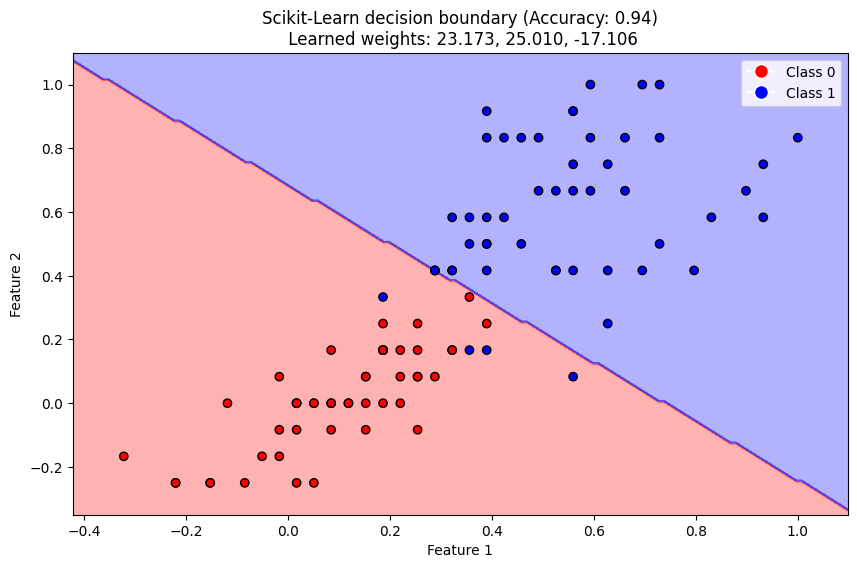

In [2]:
# Train an SGDClassifier on the binary dataset
N_ITERATIONS = 15
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

model_binary_sklearn = SklearnSGDClassifier(random_state=RANDOM_STATE, max_iter=N_ITERATIONS)

model_binary_sklearn.fit(X_binary, y_binary)

y_pred_binary_sklearn = model_binary_sklearn.predict(X_binary)

accuracy_binary_sklearn = accuracy_score(y_binary, y_pred_binary_sklearn)

plot_decision_boundary(
    X_binary,
    y_binary,
    clf=model_binary_sklearn,
    accuracy=accuracy_binary_sklearn,
    title="Scikit-Learn decision boundary",
)

## Training on Encrypted Data with Concrete ML

Training over encrypted data in FHE using SGD. Compared to the equivalent scikit-learn class, two new parameters need to be set: `fit_encrypted=True` and `parameters_range`. 

Compiling training circuit on device 'cpu'...
Compilation device override, was 'cpu' -> change to 'cuda'


Compilation took 1.6275 seconds.
Key Generation...
Key generation took 8.2259 seconds.
Training on encrypted data...


Iteration 0 took 6.47 seconds.


Iteration 1 took 4.46 seconds.


Iteration 2 took 4.24 seconds.


Iteration 3 took 4.45 seconds.


Iteration 4 took 4.39 seconds.


Iteration 5 took 4.46 seconds.


Iteration 6 took 4.41 seconds.


Iteration 7 took 4.42 seconds.


Iteration 8 took 4.33 seconds.


Iteration 9 took 4.46 seconds.


Iteration 10 took 4.46 seconds.


Iteration 11 took 4.50 seconds.


Iteration 12 took 4.40 seconds.


Iteration 13 took 4.29 seconds.


Iteration 14 took 4.42 seconds.
Compilation device override, was 'cpu' -> change to 'cuda'


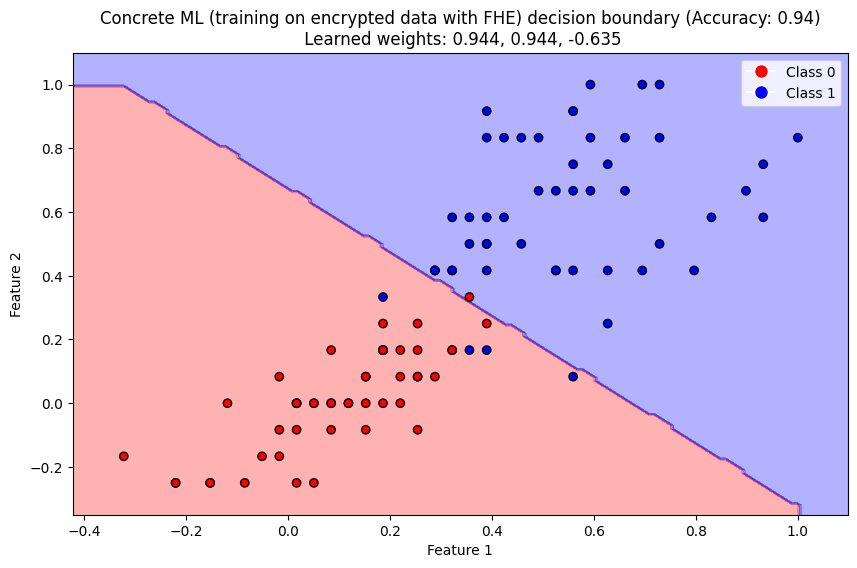

In [3]:
parameters_range = (-1.0, 1.0)

model_binary_fhe = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
    verbose=True,
)

# Fit on encrypted data
model_binary_fhe.fit(X_binary, y_binary, fhe="execute", device=device)

# The weights are decrypted at the end of the `fit` call. Use the clear weights here
# to evaluate accuracy on clear data
y_pred_binary = model_binary_fhe.predict(X_binary)

model_binary_fhe.compile(X_binary)

# Evaluate the decrypted weights on encrypted data
y_pred_binary_fhe = model_binary_fhe.predict(X_binary, fhe="execute")

# Check that the same result is obtained when applying
# the decrypted model on clear data and on encrypted data
# Linear classifiers are 100% correct on encrypted data compared to execution on clear data
assert np.all(y_pred_binary == y_pred_binary_fhe)

accuracy_binary_fhe = accuracy_score(y_binary, y_pred_binary_fhe)

plot_decision_boundary(
    X_binary,
    y_binary,
    clf=model_binary_fhe,
    accuracy=accuracy_binary_fhe,
    title="Concrete ML (training on encrypted data with FHE) decision boundary",
)

## Validate Encrypted Training using Simulation

FHE simulation is a way to test an FHE program on cleartext data, providing a fast way
to determine the behavior of an algorithm over encrypted data. Inputs and results of FHE simulation are not encrypted
but the the results are quickly obtained so they can be analyzed to show if any errors are introduced by the execution
of the algorithm with FHE.

### Get a different dataset that has more features

In [4]:
from sklearn.model_selection import train_test_split

X, y = datasets.load_breast_cancer(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

scaler = MinMaxScaler(feature_range=[-1, 1])
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

rng = np.random.default_rng(RANDOM_STATE)
perm = rng.permutation(x_train.shape[0])

x_train = x_train[perm, ::]
y_train = y_train[perm]

### Configure the FHE training algorithm and simulate

In [5]:
parameters_range = (-1.0, 1.0)

model_sklearn = SklearnSGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
)

model_sklearn.fit(x_train, y_train)

y_pred_sklearn = model_sklearn.predict(x_test)

accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"Sklearn clear accuracy: {accuracy_sklearn*100:.2f}%")

model_concrete = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
)

# Train with simulation on the full dataset
model_concrete.fit(x_train, y_train, fhe="simulate")

model_concrete.compile(x_train)

# Measure accuracy on the test set using simulation
y_pred_fhe = model_concrete.predict(x_test, fhe="simulate")

accuracy_fhe = accuracy_score(y_test, y_pred_fhe)
print(f"Full encrypted fit (simulated) accuracy: {accuracy_fhe*100:.2f}%")

Sklearn clear accuracy: 95.91%
Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Full encrypted fit (simulated) accuracy: 92.98%


### Evaluate accuracy evolution during training

Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


Compilation device override, was 'cpu' -> change to 'cuda'


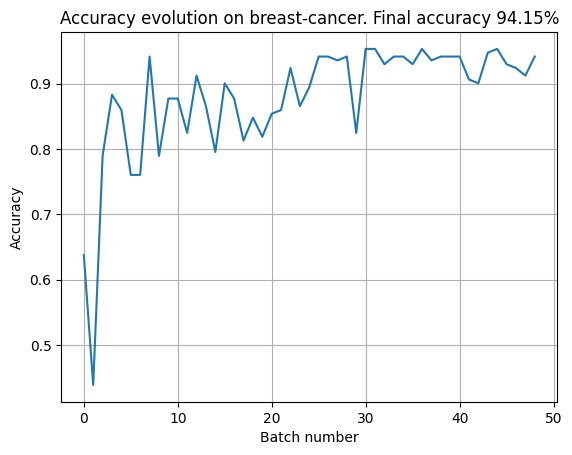

In [6]:
# To measure accuracy after every batch initialize the SGDClassifier with warm_start=True
# which keeps the weights obtained with previous batches

model_concrete_partial = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
    warm_start=True,
)

batch_size = model_concrete_partial.batch_size

classes = np.unique(y_train)

# Go through the training batches
accuracy_scores = []
for idx in range(x_train.shape[0] // batch_size):
    batch_range = range(idx * batch_size, (idx + 1) * batch_size)
    x_batch = x_train[batch_range, ::]
    y_batch = y_train[batch_range]

    # Fit on a single batch with partial_fit
    # Provide the list of all expected classes for the first iteration, as done in scikit-learn
    if idx == 0:
        model_concrete_partial.partial_fit(x_batch, y_batch, classes=classes, fhe="simulate")
    else:
        model_concrete_partial.partial_fit(x_batch, y_batch, fhe="simulate")

    model_concrete_partial.compile(x_train)

    # Measure accuracy of the model with FHE simulation
    y_pred_partial_fhe = model_concrete_partial.predict(x_test, fhe="simulate")

    accuracy_partial = accuracy_score(y_test, y_pred_partial_fhe).mean()
    accuracy_scores.append(accuracy_partial)

# Plot the evolution of accuracy throughout the training process
fig = plt.figure()
plt.plot(accuracy_scores)
plt.title(f"Accuracy evolution on breast-cancer. Final accuracy {accuracy_scores[-1]*100:.2f}%")
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## Deployment

In this section, we will prepare a model for deployment. This involves initializing the model with the necessary parameters and compiling it with sample data to ensure it is ready for production.

In [7]:
# Initialize the model with parameters
parameters_range = (-1.0, 1.0)
batch_size = 8

sgd_clf_binary_fhe = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=N_ITERATIONS,
    fit_encrypted=True,
    parameters_range=parameters_range,
)

# Generate the min and max values for X_binary and y_binary
x_min, x_max = X_binary.min(axis=0), X_binary.max(axis=0)
y_min, y_max = y_binary.min(), y_binary.max()

# Create a dataset with the min and max values for each feature, repeated to fill the batch size
x_compile_set = np.vstack([x_min, x_max] * (batch_size // 2))

# Create a dataset with the min and max values for y, repeated to fill the batch size
y_compile_set = np.array([y_min, y_max] * (batch_size // 2))

# Fit the model with the created dataset to compile it for production
# This step ensures the model knows the number of features, targets and features distribution


device = "cuda" if check_gpu_available() else "cpu"
sgd_clf_binary_fhe.fit(x_compile_set, y_compile_set, fhe="disable", device=device)

SGDClassifier(fit_encrypted=True, max_iter=15, parameters_range=(-1.0, 1.0),
              random_state=42)

In [8]:
# Define the directory where to save the deployment files
DEPLOYMENT_PATH = Path("fhe_training")
DEPLOYMENT_PATH.mkdir(exist_ok=True)

deployment_dir = TemporaryDirectory(dir=str(DEPLOYMENT_PATH))  # pylint: disable=consider-using-with
deployment_path = Path(deployment_dir.name)

In [9]:
# Save the training FHE circuit for production
fhe_dev = FHEModelDev(deployment_path, sgd_clf_binary_fhe)
fhe_dev.save(mode="training")

In [10]:
# On the client side, load the circuit.zip with the information to create
# - the key
# - the pre and post processing functions

fhe_client = FHEModelClient(deployment_path)
fhe_client.load()
serialized_evaluation_keys = fhe_client.get_serialized_evaluation_keys()

In [11]:
# On the server side, we load the server.zip which contain the training model
fhe_server = FHEModelServer(deployment_path)
fhe_server.load()

In [12]:
# Define utils function to evaluate the model


def model_inference(weights, bias, X):
    # Compute the linear model
    linear_model = np.dot(X, weights[0]) + bias[0]

    # Apply the sigmoid function
    sigmoid = 1 / (1 + np.exp(-linear_model))

    # Compute the prediction
    prediction = np.round(sigmoid)

    return prediction


def compute_model_accuracy(weights, bias, X, y):
    # Compute the prediction
    prediction = model_inference(weights, bias, X).squeeze()

    # Compute the accuracy
    return np.mean(prediction == y)

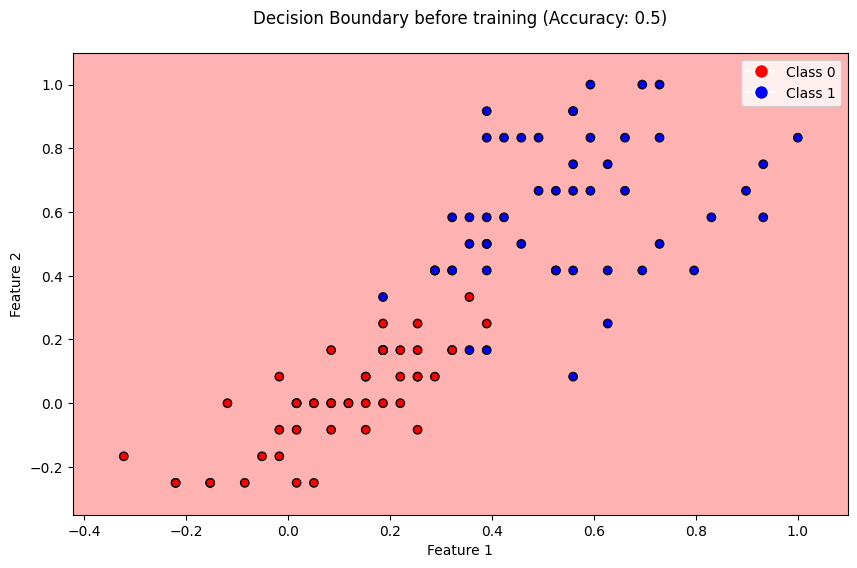

Epoch 1/1 completed. Accuracy: 0.94


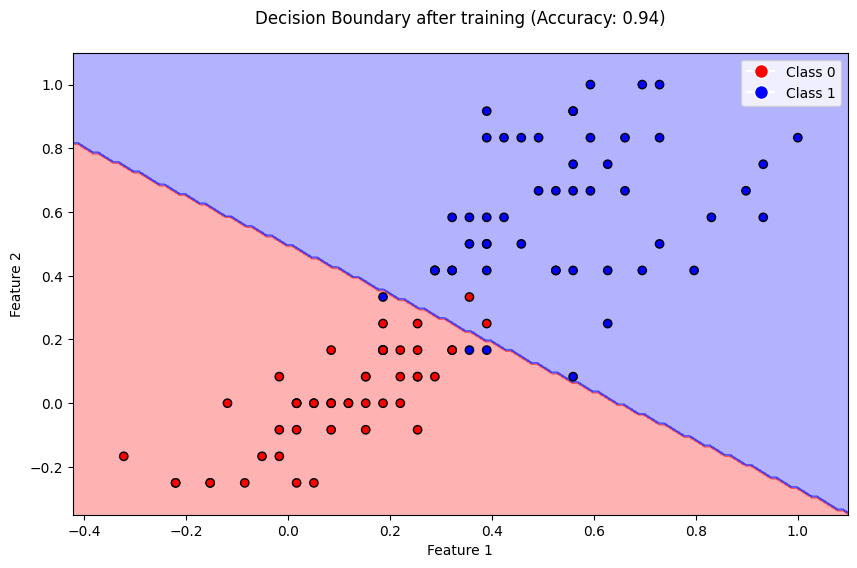

In [13]:
batch_size = sgd_clf_binary_fhe.batch_size

# Shuffle X_binary and y_binary
perm = np.random.permutation(X_binary.shape[0])
X_binary = X_binary[perm, ::]
y_binary = y_binary[perm]

# Initialize the weight and bias randomly
# They are going to be updated using FHE training.
weights = np.random.rand(1, X_binary.shape[1], 1)
bias = np.random.rand(1, 1, 1)

# Plot the decision boundaries before starting
plot_decision_boundary(
    X_binary,
    y_binary,
    weights=weights,
    bias=bias,
    title="Decision Boundary before training",
    accuracy=compute_model_accuracy(weights, bias, X_binary, y_binary),
)


def quantize_encrypt_serialize_batches(fhe_client, x, y, weights, bias, batch_size):
    x_batches_enc, y_batches_enc = [], []

    for i in range(0, x.shape[0], batch_size):

        # Avoid the last batch if it's not a multiple of 'batch_size'
        if i + batch_size < x.shape[0]:
            batch_range = range(i, i + batch_size)
        else:
            break

        # Make the data X (1, batch_size, n_features) and y (1, batch_size, n_targets=1)
        x_batch = np.expand_dims(x[batch_range, :], 0)
        y_batch = np.expand_dims(y[batch_range], (0, 2))

        # Encrypt the batch
        x_batch_enc, y_batch_enc, _, _ = fhe_client.quantize_encrypt_serialize(
            x_batch, y_batch, None, None
        )

        x_batches_enc.append(x_batch_enc)
        y_batches_enc.append(y_batch_enc)

    _, _, weights_enc, bias_enc = fhe_client.quantize_encrypt_serialize(None, None, weights, bias)

    return x_batches_enc, y_batches_enc, weights_enc, bias_enc


def server_run(fhe_server, x_batches_enc, y_batches_enc, weights_enc, bias_enc, evaluation_keys):

    weights_enc = fhe.Value.deserialize(weights_enc)
    bias_enc = fhe.Value.deserialize(bias_enc)

    evaluation_keys = fhe.EvaluationKeys.deserialize(evaluation_keys)

    # Run the circuit on the server n times, n being the number of batches sent by the user
    for x_batch, y_batch in zip(x_batches_enc, y_batches_enc):
        x_batch = fhe.Value.deserialize(x_batch)
        y_batch = fhe.Value.deserialize(y_batch)

        weights_enc, bias_enc = fhe_server.run(
            (x_batch, y_batch, weights_enc, bias_enc), evaluation_keys
        )

    weights_enc = weights_enc.serialize()
    bias_enc = bias_enc.serialize()

    return weights_enc, bias_enc


def train_fhe_client_server(
    x,
    y,
    batch_size,
    fhe_client,
    fhe_server,
    serialized_evaluation_keys,
    weights,
    bias,
    n_epochs=1,
):
    acc_history = []

    for epoch in range(n_epochs):
        # Shuffle x and y
        perm = np.random.permutation(x.shape[0])
        x = x[perm, ::]
        y = y[perm]

        # Quantize, encrypt and serialize the batched inputs as well as the weight and bias values
        x_batches_enc, y_batches_enc, weights_enc, bias_enc = quantize_encrypt_serialize_batches(
            fhe_client, x, y, weights, bias, batch_size
        )

        # Iterate the circuit over the batches on the server
        fitted_weights_enc, fitted_bias_enc = server_run(
            fhe_server,
            x_batches_enc,
            y_batches_enc,
            weights_enc,
            bias_enc,
            serialized_evaluation_keys,
        )

        # Back on the client, deserialize, decrypt and de-quantize the fitted weight and bias values
        weights, bias = fhe_client.deserialize_decrypt_dequantize(
            fitted_weights_enc, fitted_bias_enc
        )

        # Compute, store and print the epoch's accuracy
        accuracy_score = compute_model_accuracy(weights, bias, x, y)
        acc_history.append(accuracy_score)

        print(f"Epoch {epoch + 1}/{n_epochs} completed. Accuracy: {acc_history[-1]}")

    return weights, bias, acc_history


weights, bias, acc_history = train_fhe_client_server(
    X_binary,
    y_binary,
    batch_size,
    fhe_client,
    fhe_server,
    serialized_evaluation_keys,
    weights,
    bias,
)

# Plot the decision final model boundary
plot_decision_boundary(
    X_binary,
    y_binary,
    weights=weights,
    bias=bias,
    title="Decision Boundary after training",
    accuracy=acc_history[-1],
)

## Fine-Tuning on a Rotated Dataset

The encrypted training FHE circuit created allows learning parameters for different dataset as long as it has the same number of features and the floating point distribution of the input remains similar. In this section, the dataset is changed to see if the model can adapt to a task that could be seen as fine-tuning on a slightly different dataset.

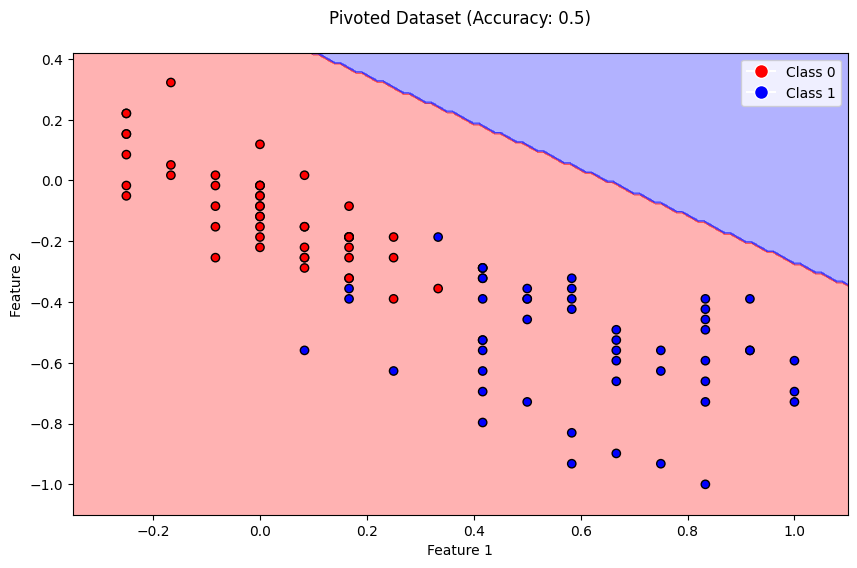

Epoch 1/2 completed. Accuracy: 0.87


Epoch 2/2 completed. Accuracy: 0.94


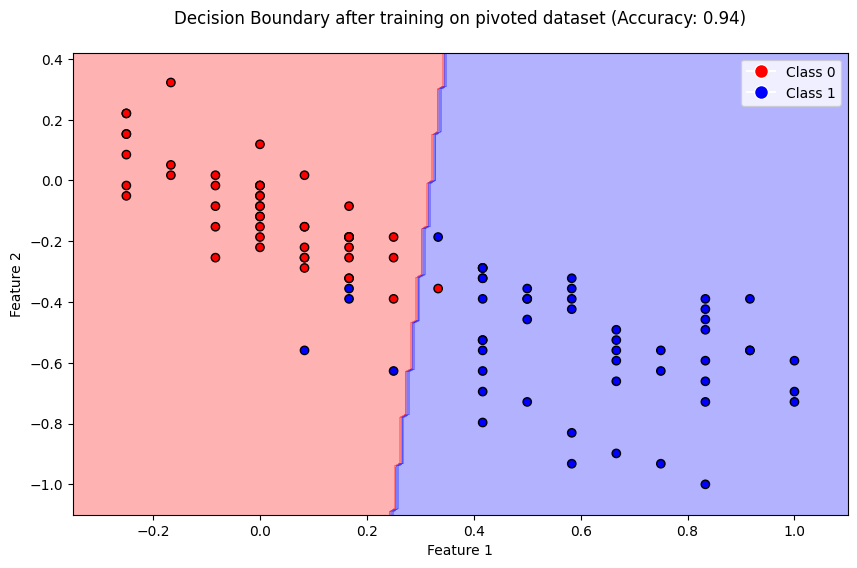

In [14]:
# Let's rotate the dataset 90 degrees and see
# if the model can learn the new dataset

# Define the 90-degree rotation matrix
rotation_matrix = np.array([[0, -1], [1, 0]])

# Apply the rotation matrix to X_binary
X_binary_pivoted = X_binary @ rotation_matrix

# Plot before training
plot_decision_boundary(
    X_binary_pivoted,
    y_binary,
    weights=weights,
    bias=bias,
    title="Pivoted Dataset",
    accuracy=compute_model_accuracy(weights, bias, X_binary_pivoted, y_binary),
)

# Train the model again with the pivoted dataset
weights_pivoted, bias_pivoted, acc_history_pivoted = train_fhe_client_server(
    X_binary_pivoted,
    y_binary,
    batch_size,
    fhe_client,
    fhe_server,
    serialized_evaluation_keys,
    weights,
    bias,
    n_epochs=2,
)

# Plot the decision boundary for the pivoted dataset
plot_decision_boundary(
    X_binary_pivoted,
    y_binary,
    weights=weights_pivoted,
    bias=bias_pivoted,
    title="Decision Boundary after training on pivoted dataset",
    accuracy=acc_history_pivoted[-1],
)

In [15]:
# Clean the temporary directories and their content
deployment_dir.cleanup()

## Conclusion

In this notebook, we have trained a logistic regression model in FHE. We have also seen how to evaluate the accuracy of the model on encrypted data and how to deploy the model for production.

Disclaimer: FHE training is a very experimental feature (e.g. only learning rate = 1 supported) and can exhibit a lot of variance during training.
